In [3]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from scipy.stats import mode

## Generate Master Darks and Flat

In [3]:
# Load fits files for 2s and 1.5s dark exposures, use ms values for naming consistency
dark_1500ms = []
dark_2000ms = []
flats = []

# Make list of 2s dark data
for i in range(0,10):
    fname = '../data/dark_R_2s.0000000{0}.DARK.FIT'.format(i+1)
    try: 
        file = fits.open(fname)
    except FileNotFoundError:
        fname = fits.open('../data/dark_R_2s.00000010.DARK.FIT')
    dark_2000ms.append(file[0].data)
    file.close()

# 1.5s dark data 
for i in range(10,20):
    fname = '../data/dark_R_1.5s.000000{0}.DARK.FIT'.format(i+1)
    file = fits.open(fname)
    dark_1500ms.append(file[0].data)
    file.close()

# Flats data
for i in range(0,10):
    fname = '../data/flat_R.0000000{0}.FIT'.format(i+1)
    try: 
        file = fits.open(fname)
    except FileNotFoundError:
        fname = fits.open('../data/flat_R.00000010.FIT')
    flats.append(file[0].data)
    file.close()
    
m_dark_1500ms = np.empty(shape=dark_1500ms[0].shape)       # Make blank arrays of 1024 by 1024
m_dark_2000ms = np.empty(shape=dark_2000ms[0].shape)
m_flat = np.zeros(shape=flats[0].shape)
for y in range(1024):                          # For each y value
    for x in range(1024):                      # and each x value
        pixel_val_1500ms = []                             
        pixel_val_2000ms = []
        pixel_val_flat = []
        for dark in dark_1500ms:                           # and every frame
            pixel_val_1500ms.append(dark[y][x])     # Make a list of the value in the y,x pixel for 1.5s darks
        for dark in dark_2000ms:                              
            pixel_val_2000ms.append(dark[y][x])     # and the 2s darks
        for flat in flats:
            pixel_val_flat.append(flat[y][x])              # and the flats

        m_dark_1500ms[y][x] = np.median(pixel_val_1500ms)  # And store median value to the y,x pixel of the right master
        m_dark_2000ms[y][x] = np.median(pixel_val_2000ms)
        m_flat[y][x] = np.median(pixel_val_flat)
        
# Normalize master flat to have relative intensities varying around 1
m_flat /= np.mean(m_flat)

## Apply master fields to science images

In [146]:
'''
# Process science images with flats and darks (subtract dark, divide by flat)
# Comment this block out once run the first time, processing intensive and only needs to be done once to make the files

# Change working directory for processed data
os.chdir('../jupyter/')
print(os.getcwd())
os.chdir('../processed_data/')
print(os.getcwd())

# File extensions
files2000ms = np.array([*range(1, 902)])
files1500ms = np.array([*range(1001, 1193)])
files1500ms = np.append(files1500ms, [*range(2001, 3177)])
sequential_data = []
series = 0                                                               # Keep sequential file numbers
for i in files2000ms:
    file = fits.open('../data/hd209458_R_2s_start_series1000.0000{}.FIT'.format(str(i).zfill(4)))
    test_file = fits.PrimaryHDU((file[0].data-m_dark_2000ms)/m_flat)
    test_file.writeto('hd209458_processed_{}.fits'.format(str(series).zfill(5)), overwrite=True)
    file.close()
    series += 1
for i in files1500ms:
    file = fits.open('../data/hd209458_R_1_5s_start_series1000.0000{}.FIT'.format(str(i).zfill(4)))
    test_file = fits.PrimaryHDU((file[0].data-m_dark_1500ms)/m_flat)
    test_file.writeto('hd209458_processed_{}.fits'.format(str(series).zfill(5)), overwrite=True)
    file.close()
    series += 1

#'''

/home/nicholas/documents/schoolwork/ast443/ast443-nyc/lab1/jupyter
/home/nicholas/documents/schoolwork/ast443/ast443-nyc/lab1/processed_data


## Bad Pixel Map

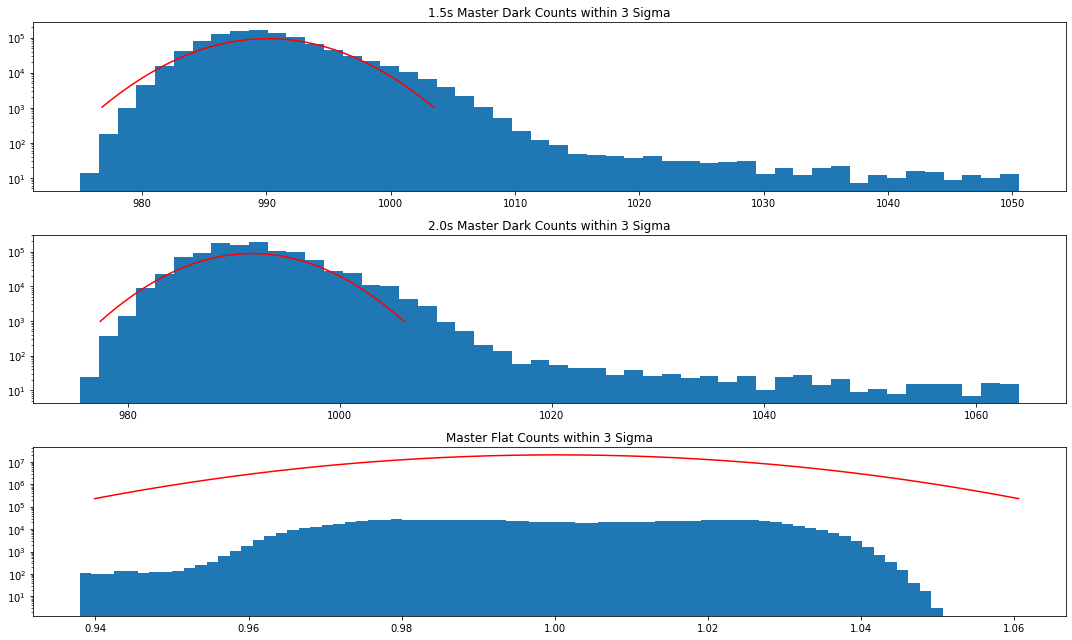

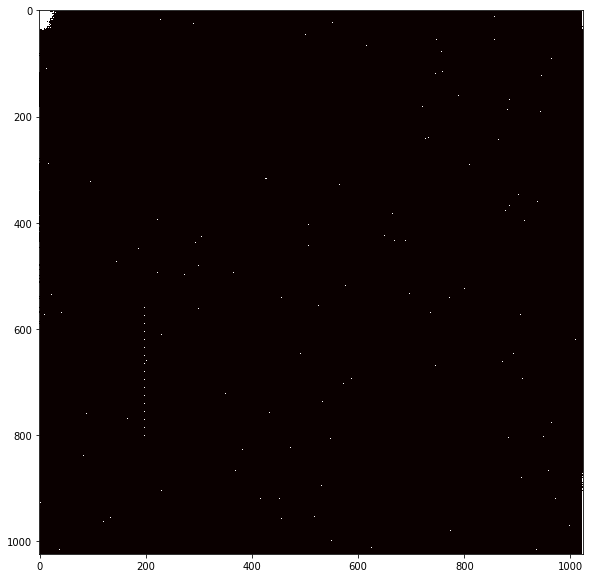

In [8]:
# Find stats for masters
flat_mean = np.mean(m_flat)
dark_mean1500 = np.mean(m_dark_1500ms)
dark_mean2000 = np.mean(m_dark_2000ms)
flat_std = np.std(m_flat)
dark_std1500 = np.std(m_dark_1500ms)
dark_std2000 = np.std(m_dark_2000ms)

# Significance level for cuts ------------------------------------------------- EDITABLE FOR VARIOUS NEEDS
siglevel = 3

# Define a gaussian function
def gaussian(mu, std):
    x = np.linspace(mu-siglevel*std, mu+siglevel*std, 200)
    func = np.exp(-pow((x-mu)/std, 2)/2)
    func /= np.sqrt(2*np.pi*std*std)
    func *= 1024*1024
    return x, func

# Cur the data to be within  sigma
dark_1500ms_cut = [x for x in m_dark_1500ms.flatten() if x < dark_mean1500+siglevel*dark_std1500 
                   and x > dark_mean1500-siglevel*dark_std1500]
dark_2000ms_cut = [x for x in m_dark_2000ms.flatten() if x < dark_mean2000+siglevel*dark_std2000 
                   and x > dark_mean2000-siglevel*dark_std2000]
flat_cut = [x for x in m_flat.flatten() if x < flat_mean+siglevel*flat_std and x > flat_mean-siglevel*flat_std]

# Plot histograms
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.hist(dark_1500ms_cut, log=True, bins=50)
ax2.hist(dark_2000ms_cut, log=True, bins=50)
ax3.hist(flat_cut, log=True, bins=75)
ax1.set_title('1.5s Master Dark Counts within 3 Sigma')
ax2.set_title('2.0s Master Dark Counts within 3 Sigma')
ax3.set_title('Master Flat Counts within 3 Sigma')
ax1.plot(*gaussian(np.mean(dark_1500ms_cut), np.std(dark_1500ms_cut)), 'r-')
ax2.plot(*gaussian(np.mean(dark_2000ms_cut), np.std(dark_2000ms_cut)), 'r-')
ax3.plot(*gaussian(np.mean(flat_cut), np.std(flat_cut)), 'r-')
fig.tight_layout()
plt.show()
plt.close()

# Make bad pixel map and plot
bad_pixel_map = np.ones(shape=(1024, 1024))
for y in range(1024):
    for x in range(1024):
        if (m_dark_1500ms[y][x] > dark_mean1500+siglevel*dark_std1500 or 
            m_dark_1500ms[y][x] < dark_mean1500-siglevel*dark_std1500):
            bad_pixel_map[y][x] = 0
        elif (m_dark_2000ms[y][x] > dark_mean2000+siglevel*dark_std2000 or 
              m_dark_2000ms[y][x] < dark_mean2000-siglevel*dark_std2000):
            bad_pixel_map[y][x] = 0
        elif m_flat[y][x] > flat_mean+siglevel*flat_std or m_flat[y][x] < flat_mean-siglevel*flat_std:
            bad_pixel_map[y][x] = 0
fig = plt.figure(figsize=(10, 10))
plt.imshow(bad_pixel_map, cmap='hot_r')
plt.show()

## Reference Star Lightcurves

['refstar8_2.dat', 'refstar7_2.dat', 'refstar1_2.dat', 'refstar4_2.dat', 'refstar6_2.dat', 'refstar3_2.dat', 'refstar2_2.dat', 'refstar5_2.dat']
['refstar1_1.5.dat', 'refstar2_1.5.dat', 'refstar3_1.5.dat', 'refstar5_1.5.dat', 'refstar6_1.5.dat', 'refstar8_1.5.dat', 'refstar4_1.5.dat', 'refstar7_1.5.dat']


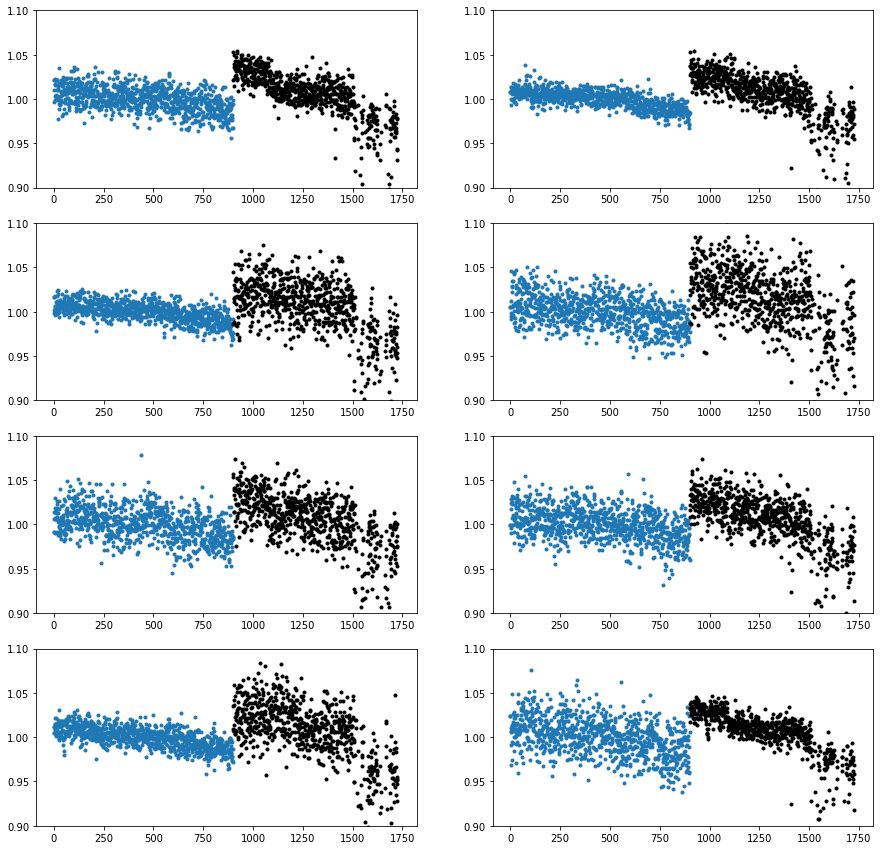

In [52]:
files = os.listdir('../lightcurve')

file_2s = [file for file in files if file[-5:-4] == str(2)]      # Grab the 2s exposure catalogs
file_1_5s = [file for file in files if file[-5:-4] == str(5)]      # Grab the 1.5s exposure catalogs

print(file_2s)
print(file_1_5s)

fig, ax = plt.subplots(4, 2, figsize=(15, 15))
ax = ax.flatten()

for i in range(len(file_2s)):
    data = np.loadtxt('../lightcurve/{0}'.format(file_2s[i]))
    fnum, count, sigcount = data.T
    flux = count/2
    
    flux_mu = np.mean(flux)
    flux_sig = np.std(flux)
    
    flux /= np.mean([x for x in flux if x > flux_mu-flux_sig and x < flux_mu+flux_sig])
    sigflux = sigcount/2
    sigflux /= np.mean([x for x in flux if x > flux_mu-flux_sig and x < flux_mu+flux_sig])
    ax[i].plot(fnum, flux, '.')
    
for i in range(len(file_1_5s)):
    data = np.loadtxt('../lightcurve/{0}'.format(file_1_5s[i]))
    fnum, count, sigcount = data.T    
    fnum += 901
    flux = count/1.5
    
    flux_mu = np.mean(flux)
    flux_sig = np.std(flux)
    
    flux /= np.mean([x for x in flux if x > flux_mu-flux_sig and x < flux_mu+flux_sig])
    sigflux = sigcount/1.5
    sigflux /= np.mean([x for x in flux if x > flux_mu-flux_sig and x < flux_mu+flux_sig])
    ax[i].plot(fnum, flux, 'k.')
    
    ax[i].set_ylim(.9, 1.1)


['refstar1_2.dat', 'refstar2_2.dat', 'refstar3_2.dat', 'refstar4_2.dat', 'refstar5_2.dat', 'refstar6_2.dat', 'refstar7_2.dat', 'refstar8_2.dat']
['refstar1_1.5.dat', 'refstar2_1.5.dat', 'refstar3_1.5.dat', 'refstar4_1.5.dat', 'refstar5_1.5.dat', 'refstar6_1.5.dat', 'refstar7_1.5.dat', 'refstar8_1.5.dat']


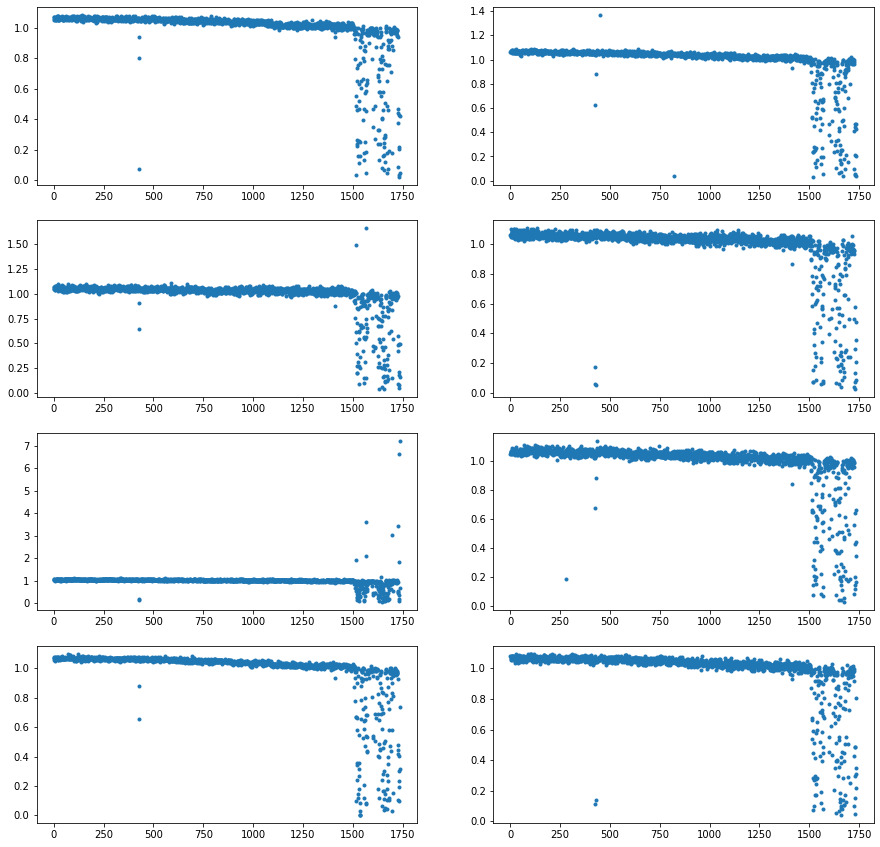

In [60]:
files = sorted(os.listdir('../lightcurve'))

file_2s = [file for file in files if file[-5:-4] == str(2)]      # Grab the 2s exposure catalogs
file_1_5s = [file for file in files if file[-5:-4] == str(5)]      # Grab the 1.5s exposure catalogs

print(file_2s)
print(file_1_5s)

fig, ax = plt.subplots(4, 2, figsize=(15, 15))
ax = ax.flatten()

for i in range(len(file_2s)):
    data1 = np.loadtxt('../lightcurve/{0}'.format(file_2s[i]))
    fnum1, count1, sigcount1 = data1.T
    flux1 = count1/2
    sigflux1 = sigcount1/2
    
    data2 = np.loadtxt('../lightcurve/{0}'.format(file_1_5s[i]))
    
    fnum2, count2, sigcount2 = data2.T
    fnum2 += 901
    flux2 = count2/1.5
    sigflux2 = sigcount2/1.5
    
    flux2_mu = np.mean(flux2)
    flux2_sig = np.std(flux2)
    
    fnum = np.append(fnum1, fnum2)
    flux = np.append(flux1, flux2)
    sigflux = np.append(sigflux1, sigflux2)
    
    flux /= np.mean(flux)
    sigflux /= np.mean(flux)

    ax[i].plot(fnum, flux, '.')
